<a href="https://colab.research.google.com/github/anish-nagariya/Shopping-Prediction-Model/blob/main/stock_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from polygon import RESTClient
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Activation

API_KEY = 'vqeohd8x5k1x6PKiisJQS8RgS3A1iRQC'

In [3]:
def get_all_data(ticker, api_key):
    f = open('ticker_folder/' + ticker + '.csv', 'w')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=1, timespan='day',
                                                 from_='1999-07-12', to='2021-02-03', unadjusted=False,
                                                 sort='asc', limit=50000)
        resp = resp.results
        f.write('timestamp,open,low,high,volume,close\n')
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open('ticker_folder/' + ticker + '.csv', 'r')
    df = pd.read_csv(f)
    return df

In [4]:
df = get_all_data('BRK.B', API_KEY)
df.tail()

,timestamp,open,low,high,volume,close
4361,1611810000000,229.7600,228.160,233.51,6048784.0,230.95
4362,1611896400000,229.4500,227.210,229.97,6485196.0,227.87
4363,1612155600000,229.9699,228.040,230.50,4202895.0,229.32
4364,1612242000000,231.2100,230.665,233.43,5375828.0,232.24
4365,1612328400000,232.4000,231.280,233.16,3900045.0,232.68


In [5]:
df = df.drop(['timestamp'], axis=1)
df.tail()

,open,low,high,volume,close
4361,229.7600,228.160,233.51,6048784.0,230.95
4362,229.4500,227.210,229.97,6485196.0,227.87
4363,229.9699,228.040,230.50,4202895.0,229.32
4364,231.2100,230.665,233.43,5375828.0,232.24
4365,232.4000,231.280,233.16,3900045.0,232.68


In [6]:
def split_data(data):
    days = len(data)
    data_training = data[:days - 60]
    data_testing = data[days - 60:]
    scaler = MinMaxScaler()
    training_data = data_training.copy()
    data_training = scaler.fit_transform(data_training)
    x_train, y_train, x_test, y_test = [], [], [], []

    for i in range(60, data_training.shape[0]):
        x_train.append(data_training[i - 60: i])
        y_train.append(data_training[i, 0])

    past_60_days = training_data.tail(60)
    df = past_60_days.append(data_testing, ignore_index=True)
    inputs = scaler.transform(df)

    for i in range(60, inputs.shape[0]):
        x_test.append(inputs[i - 60:i])
        y_test.append(inputs[i, 0])

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)

    return x_train, y_train, x_test, y_test, scaler.scale_[0]


In [7]:
def create_neural_network():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=50, activation='relu', input_shape=(60, 5), return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=80, activation='relu', return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=100, activation='relu', return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=120, activation='relu', return_sequences=False)))
    model.add(Dropout(0.1))

    model.add(Dense(units=50))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    return model

In [8]:
def visualize_prediction(predictions, y_test, ticker):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, c='r', label='Real ' + ticker + ' stock price')
    plt.plot(predictions, c='b', label='Predicted ' + ticker + ' stock price')
    plt.xlabel('time')
    plt.ylabel(ticker + ' Stock Price')
    plt.legend()
    plt.show()

In [9]:
API_KEY = 'vqeohd8x5k1x6PKiisJQS8RgS3A1iRQC'
tickers = [
    'MSFT', 'AAPL', 'AMZN', 'GOOG', 'GOOGL',
    'FB', 'BRK.B', 'JNJ', 'V',
    'PG','JPM', 'UNH', 'MA', 'INTC', 'VZ',
    'HD', 'T', 'PFE', 'MRK', 'PEP'
    ]
ticker = 'BRK.B'

In [10]:
def main():
    df = get_all_data(ticker, API_KEY)
    df = df.drop(['timestamp'], axis=1)
    x_train, y_train, x_test, y_test, scaler = split_data(df)
    scale = 1/scaler

    model = create_neural_network()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=5, batch_size=24)
    predictions = model.predict(x_test)
    model.save('models/' + ticker)

    y_test = y_test * scale
    predictions = predictions * scale
    visualize_prediction(predictions, y_test, ticker)


Epoch 1/5
177/177 [==============================] - 93s 450ms/step - loss: 0.0194
Epoch 2/5
177/177 [==============================] - 79s 449ms/step - loss: 0.0015
Epoch 3/5
177/177 [==============================] - 79s 447ms/step - loss: 0.0012
Epoch 4/5
177/177 [==============================] - 87s 491ms/step - loss: 0.0011
Epoch 5/5
177/177 [==============================] - 80s 450ms/step - loss: 9.3769e-04
INFO:tensorflow:Assets written to: models/BRK.B/assets


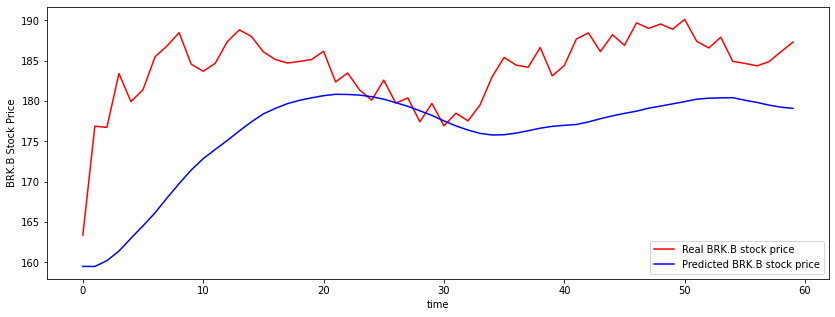

In [11]:
if __name__ == "__main__":
    main()

 **Funtions that are created for future usage:**

---



In [12]:
def get_all_news(ticker, api_key):  # function works on pycharm, however google colab cannot open the csv file
    f = open(ticker + '_news.csv', 'w')
    f.write('date,title\n')
    with RESTClient(api_key) as client:
        for j in range(25):
            resp = client.reference_ticker_news(symbol=ticker, perpage=50, page=j)
            for i in range(50):
                f.write(resp.news[i].timestamp + ',' + resp.news[i].title + '\n')
    f.close()

In [13]:

def get_minute_data(ticker, api_key, last_minutes):  # gets minute by minute data for last (last_minutes) minutes
    f = open('recent_ticker_data/' + ticker + '.csv', 'w')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=1, timespan='minute',
                                                 from_='1999-07-12', to='2021-02-03', unadjusted=False,
                                                 sort='desc', limit=last_minutes)
        resp = resp.results
        f.write('timestamp,open,low,high,volume,close\n')
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ',' + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
        f.close()
    f = open('recent_ticker_data/' + ticker + '.csv', 'r')
    df = pd.read_csv(f)
    return df

In [14]:
df = get_minute_data('BRK.B', API_KEY, 50)
df.head()

,timestamp,open,low,high,volume,close
0,1612399860000,233.01,233.01,233.01,100,233.01
1,1612399260000,233.20,233.20,233.20,214,233.20
2,1612399200000,233.01,233.01,233.01,300,233.01
3,1612399140000,233.01,233.01,233.01,100,233.01
4,1612398060000,233.20,233.20,233.20,788,233.20


In [15]:
def load_model(ticker):
    model = keras.models.load_model('models/' + ticker)
    df = pd.read_csv('ticker_folder/' + ticker + '.csv')
    df = df.drop(['timestamp'], axis=1)
    x_train, y_train, x_test, y_test, scaler = split_data(df)
    predictions = model.predict(x_test)

    scale = 1 / scaler
    predictions = predictions * scale
    y_test = y_test * scale
    visualize_prediction(predictions, y_test, ticker)

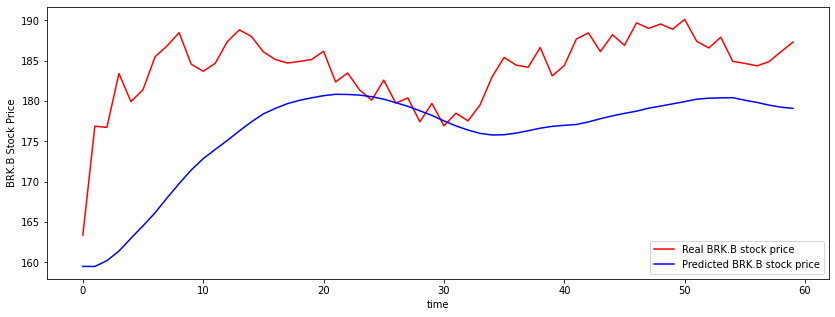

In [16]:
load_model('BRK.B')

In [17]:
def get_polarity(headline):
    analysis = TextBlob(headline)
    return analysis.polarity

In [18]:
polarity = get_polarity('BRK.B is a good stock to buy')
print('polarity: ' + str(polarity))

polarity: 0.7
